In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
### Initial imports
import logging
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessor

%matplotlib inline

import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Smoothing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Albania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Andorra
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Estonia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Iceland
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Latvia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Lithuania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing New Zealand
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Singapore
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Slovakia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Masking


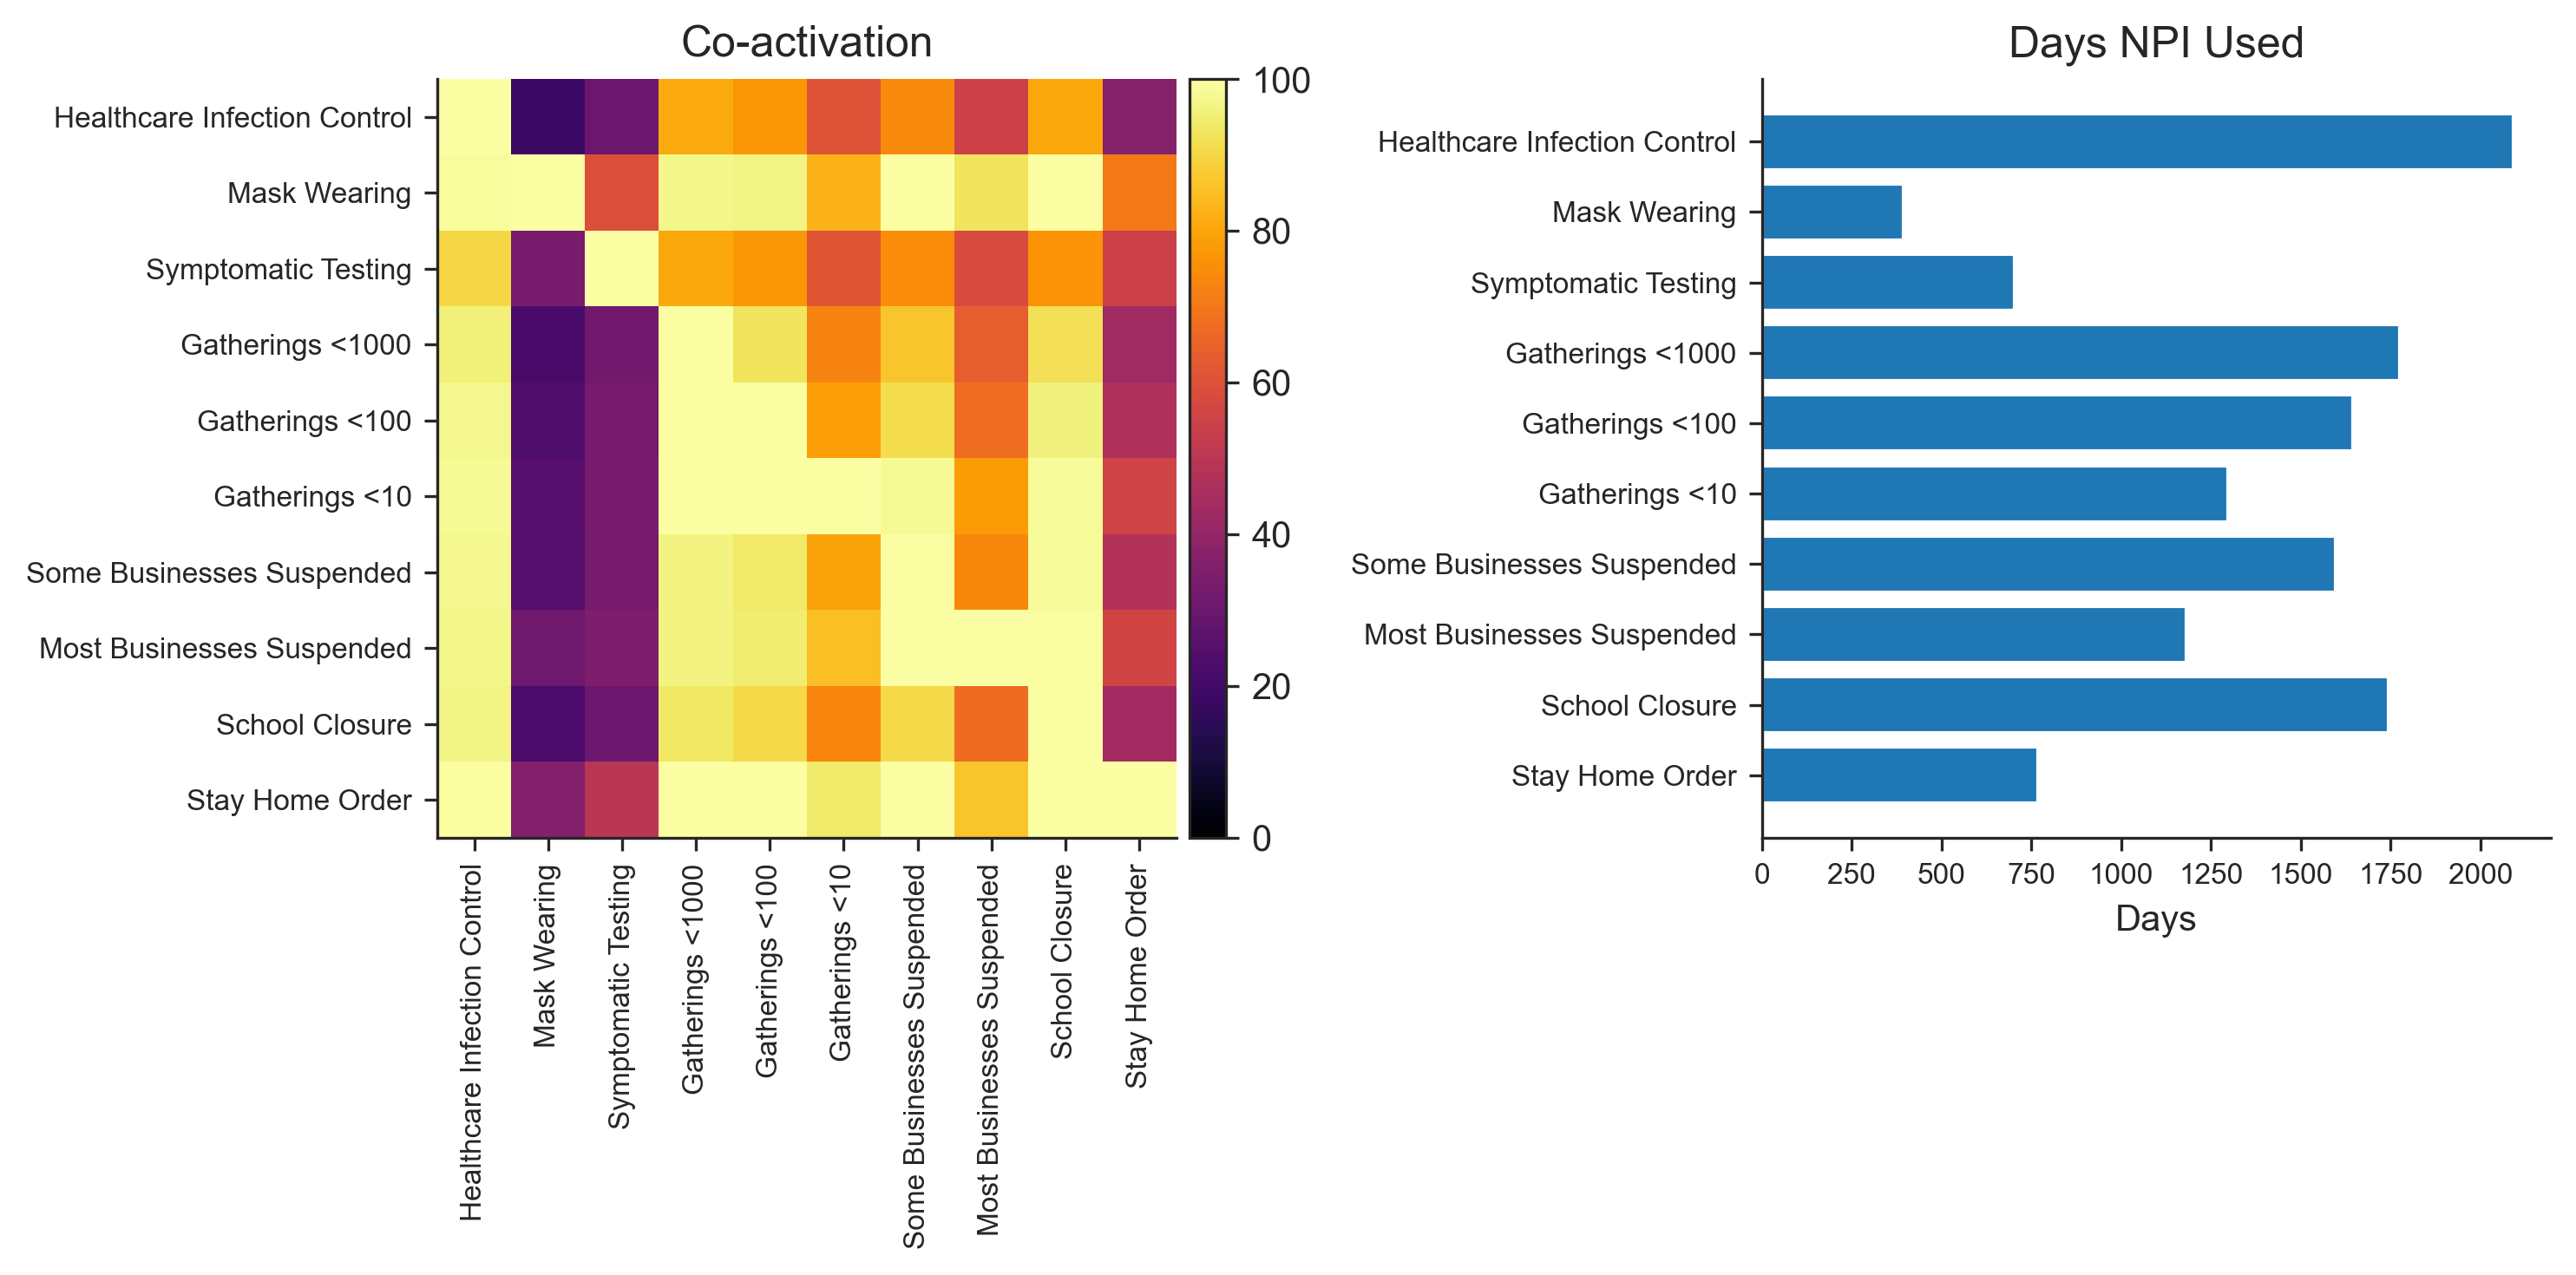

In [3]:
dp = DataPreprocessor()
data = dp.preprocess_data("data_final.csv")

In [4]:
# data.filter_region_min_deaths(100)

In [5]:
def mask_region_ends(d, region, ndays=10):
    i = d.Rs.index(region)
    d.Active.mask[i,-ndays:] = True
    d.Confirmed.mask[i,-ndays:] = True
    d.Deaths.mask[i,-ndays:] = True
    d.NewDeaths.mask[i,-ndays:] = True
    d.NewCases.mask[i,-ndays:] = True

for region in data.Rs:
    mask_region_ends(data, region, 7)

mask_region_ends(data, "ES", 40)
mask_region_ends(data, "FR", 40)

In [13]:
with cm_effect.models.CMActive_Final_ICL(data) as model:
    model.build_model()

In [14]:
model.profile(model.logpt).summary()

Function profiling
  Message: /Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/pymc3/model.py:1023
  Time in 1000 calls to Function.__call__: 1.496843e+00s
  Time in Function.fn.__call__: 1.455996e+00s (97.271%)
  Time in thunks: 1.097945e+00s (73.351%)
  Total compile time: 5.831878e-01s
    Number of Apply nodes: 890
    Theano Optimizer time: 1.525879e-05s
       Theano validate time: 0.000000e+00s
    Theano Linker time (includes C, CUDA code generation/compiling): 4.748220e-01s
       Import time 0.000000e+00s
       Node make_thunk time 4.530749e-01s
           Node InplaceDimShuffle{x}(Elemwise{log,no_inplace}.0) time 1.619101e-03s
           Node InplaceDimShuffle{x}(TensorConstant{2}) time 1.526833e-03s
           Node Elemwise{mul,no_inplace}(Elemwise{mul,no_inplace}.0, TensorConstant{[[0.046563..00025036]]}) time 1.288176e-03s
           Node InplaceDimShuffle{x}(TensorConstant{0}) time 1.277924e-03s
           Node Inpla

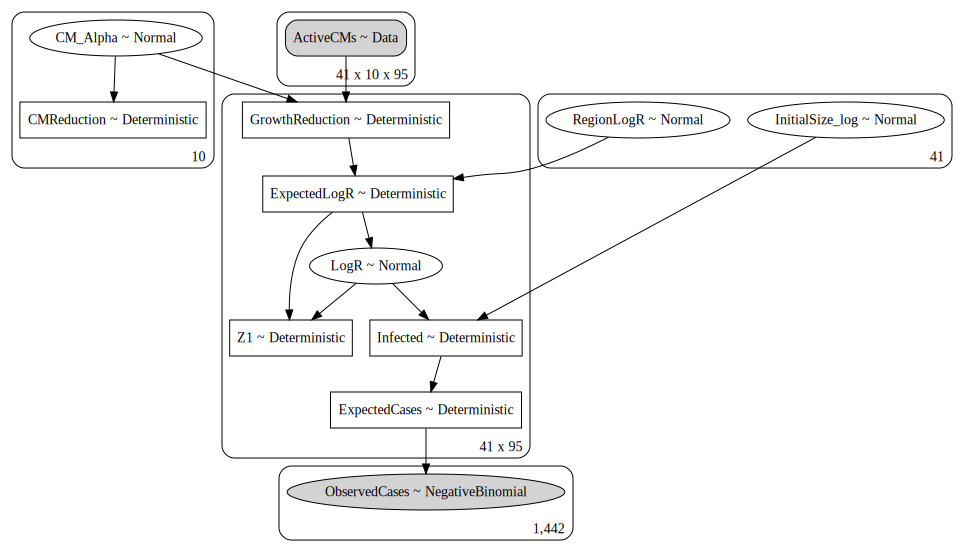

In [15]:
pm.model_to_graphviz(model).render("model-active-final-ICL")
pm.model_to_graphviz(model)

In [ ]:
with model.model:
    step = pm.Metropolis()
    map_estimate = pm.find_MAP()
    model.trace = pm.sample(2000, step, start=map_estimate)

logp = -5,699.3, ||grad|| = 1.7768: 100%|██████████| 4424/4424 [01:02<00:00, 71.09it/s] 
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [InitialSize_log]
INFO:pymc3:>Metropolis: [InitialSize_log]
>Metropolis: [LogR]
INFO:pymc3:>Metropolis: [LogR]
>Metropolis: [RegionLogR]
INFO:pymc3:>Metropolis: [RegionLogR]
>Metropolis: [CM_Alpha]
INFO:pymc3:>Metropolis: [CM_Alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:40<00:00, 247.43draws/s]


In [ ]:
model.plot_effect()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x18bf31410>,
      dtype=object)

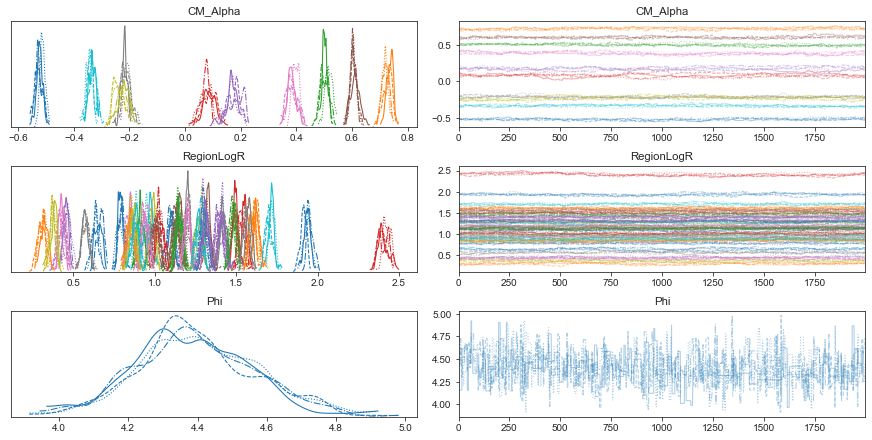

In [24]:
pm.traceplot(model.trace, ["CM_Alpha", "RegionLogR", "Phi"])

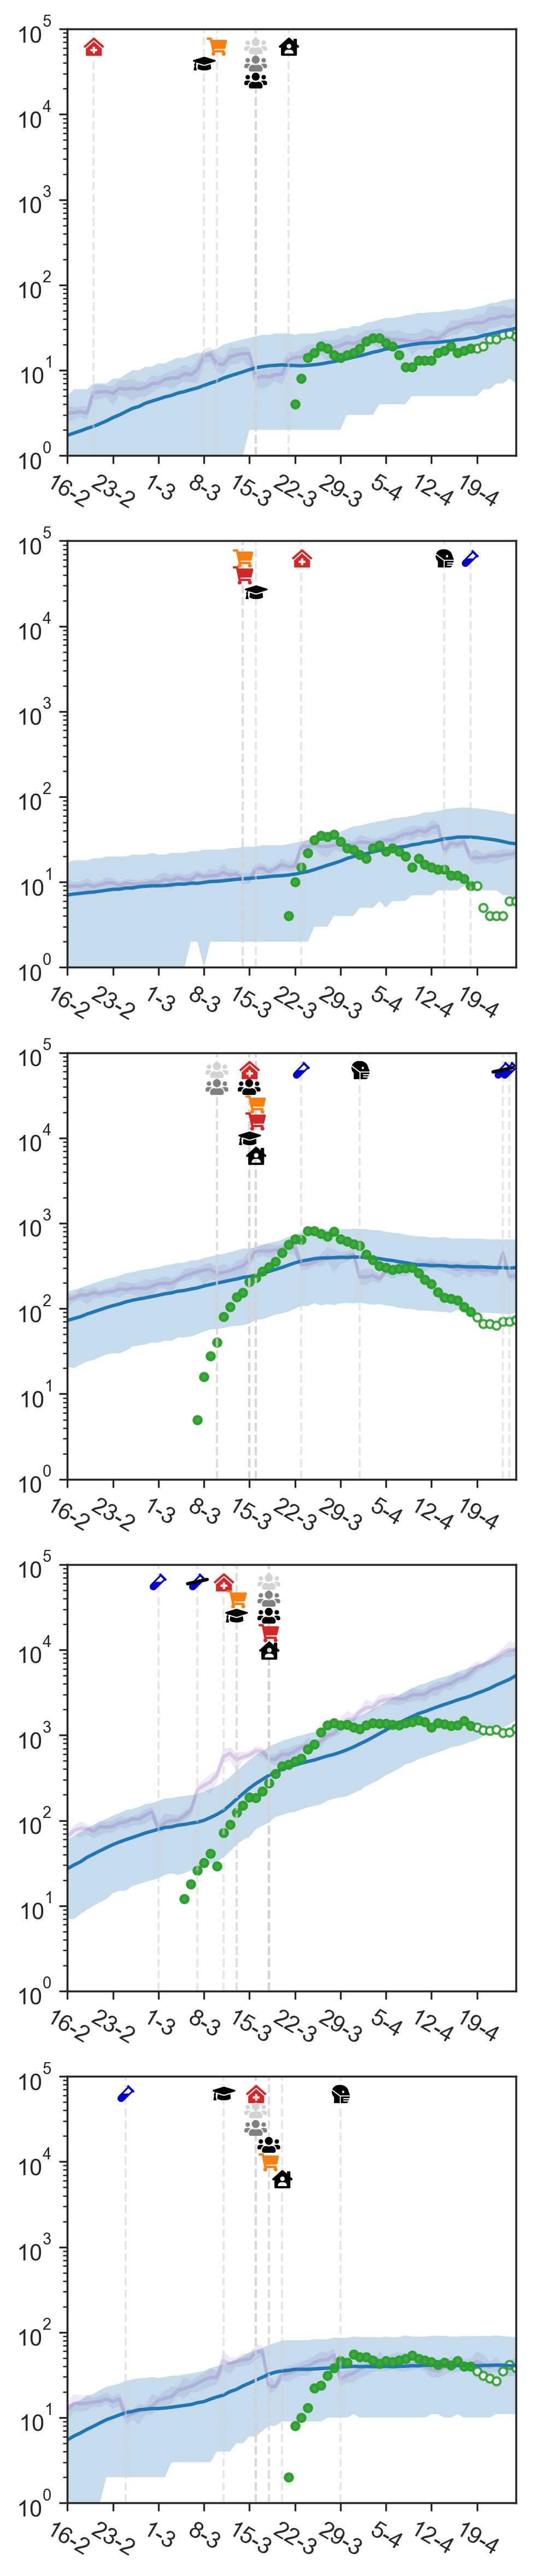

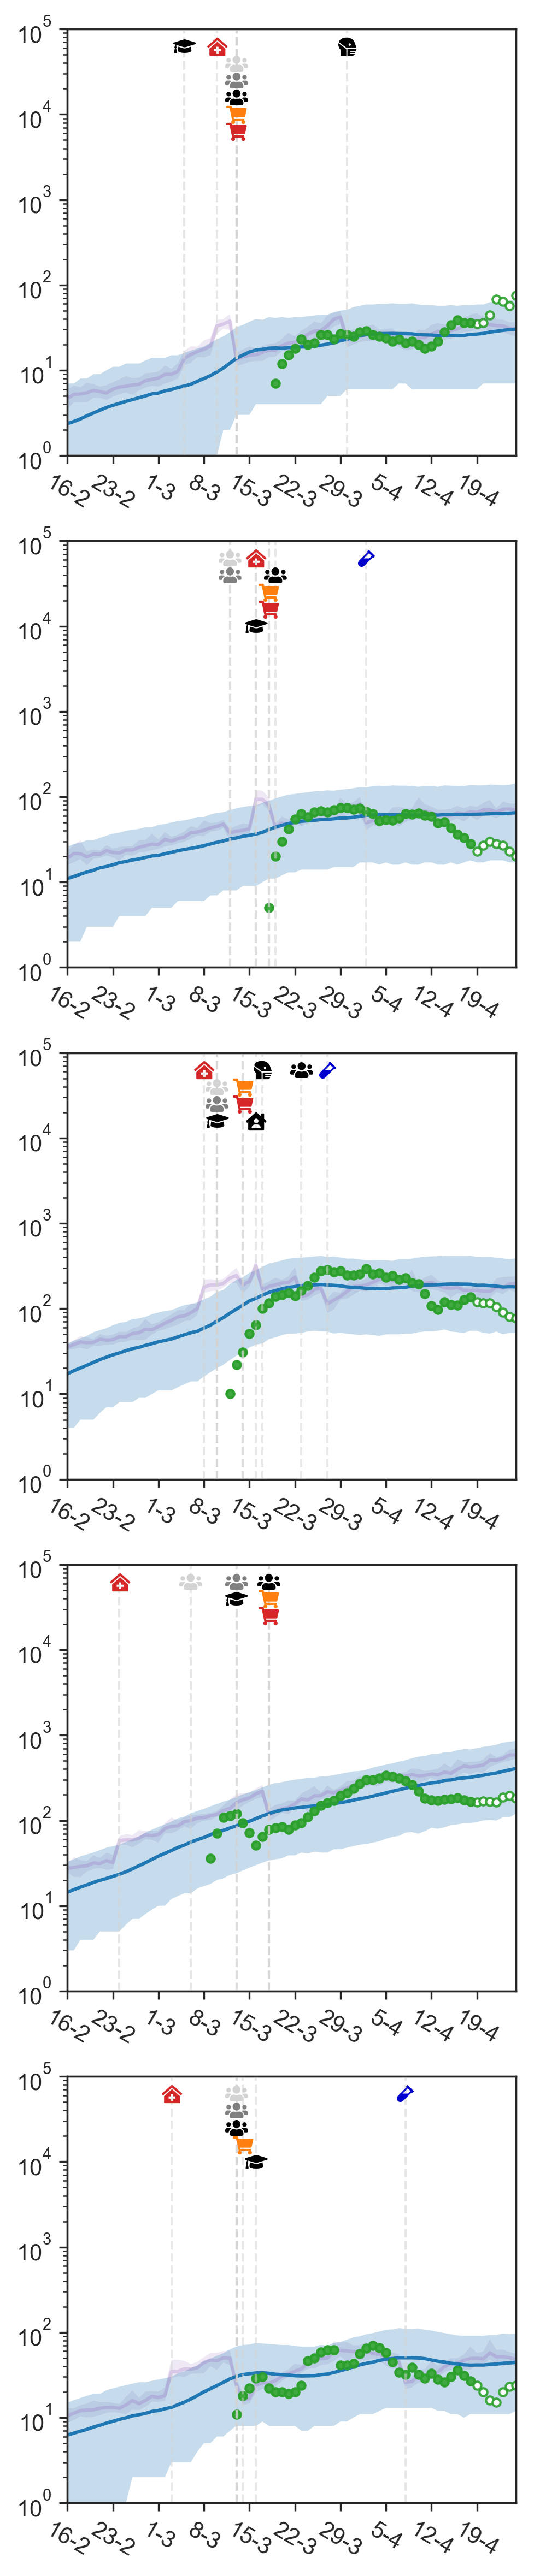

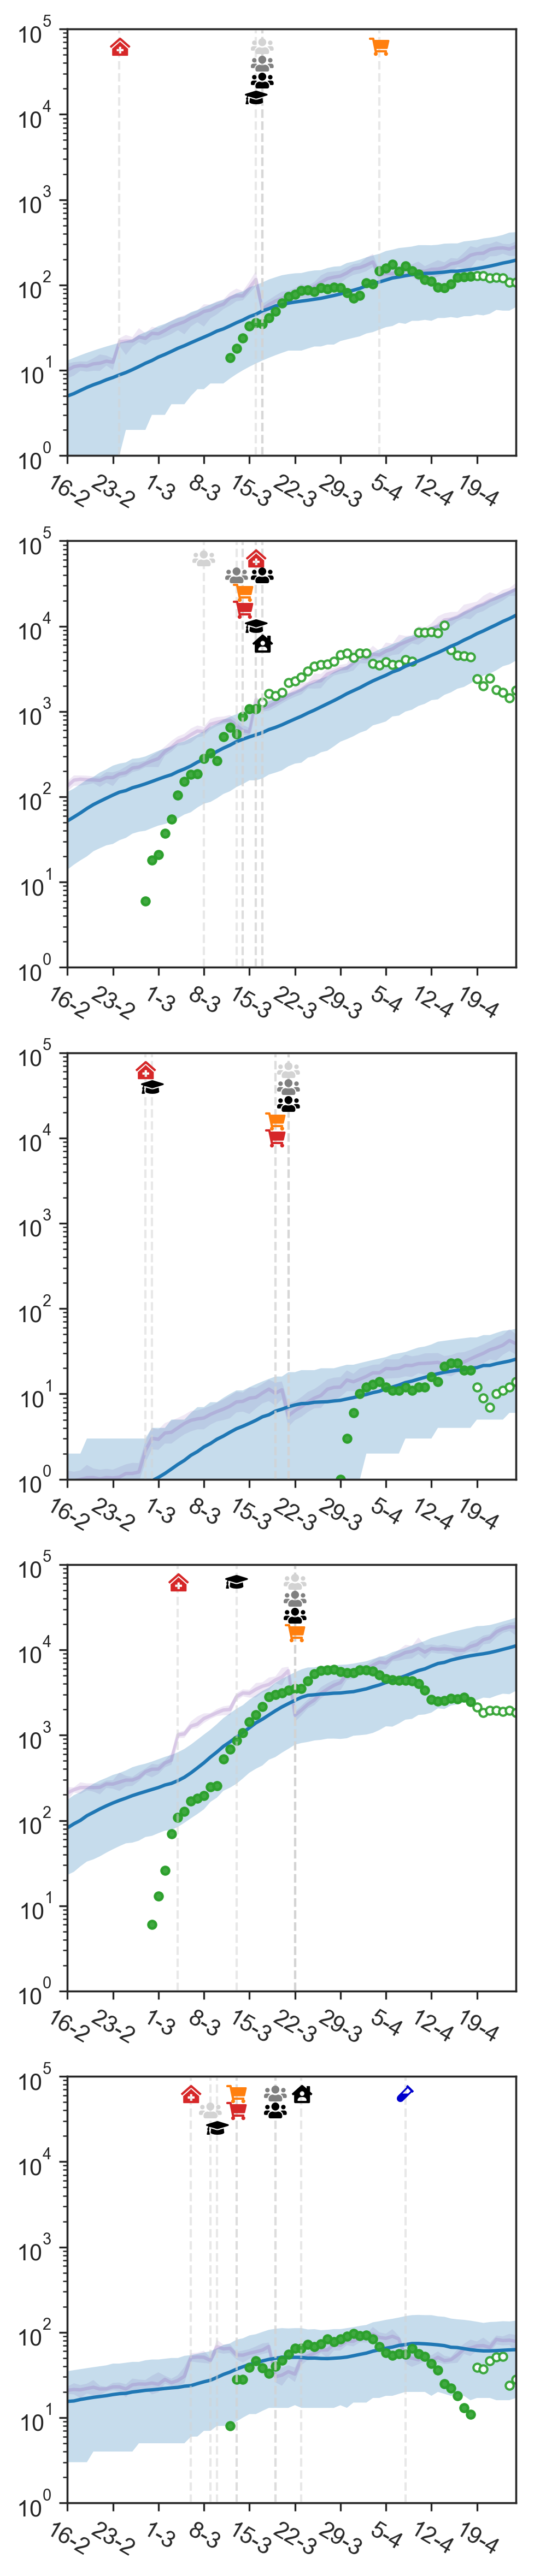

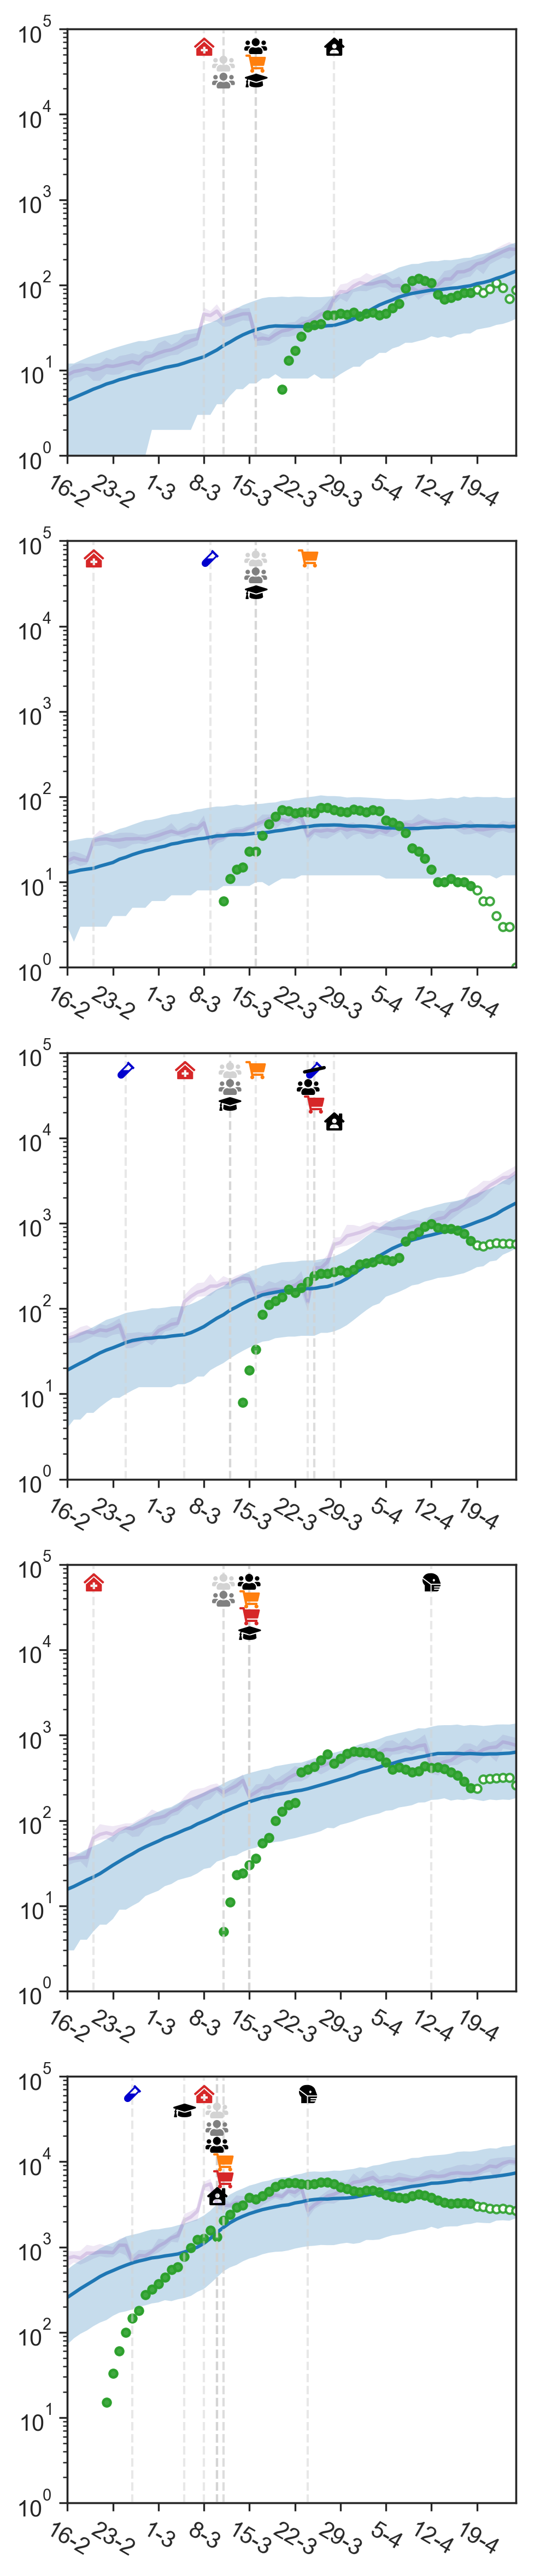

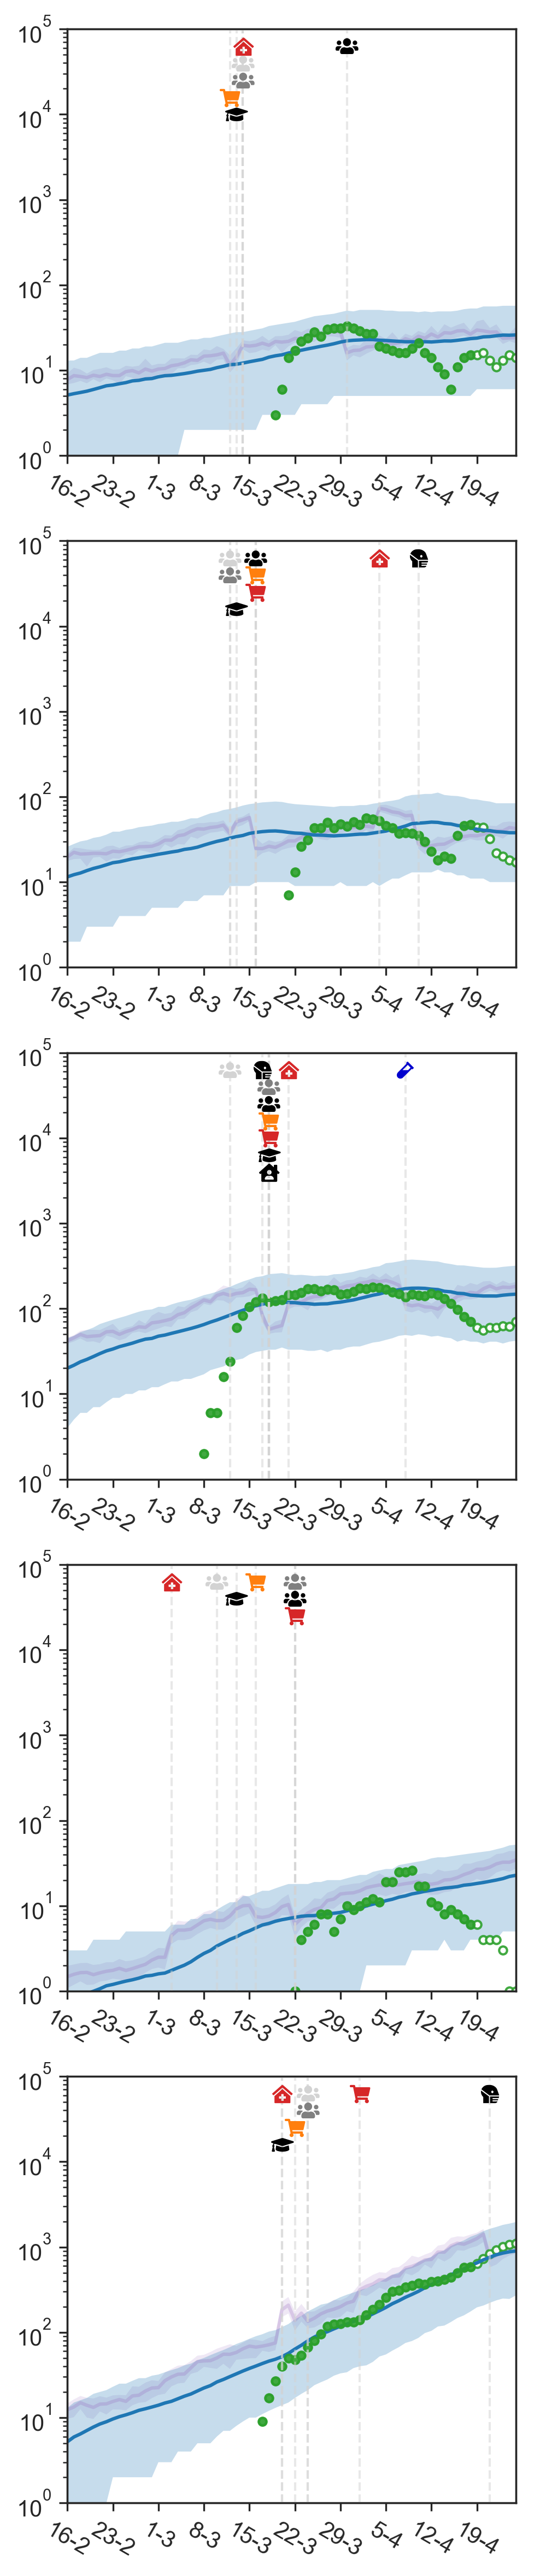

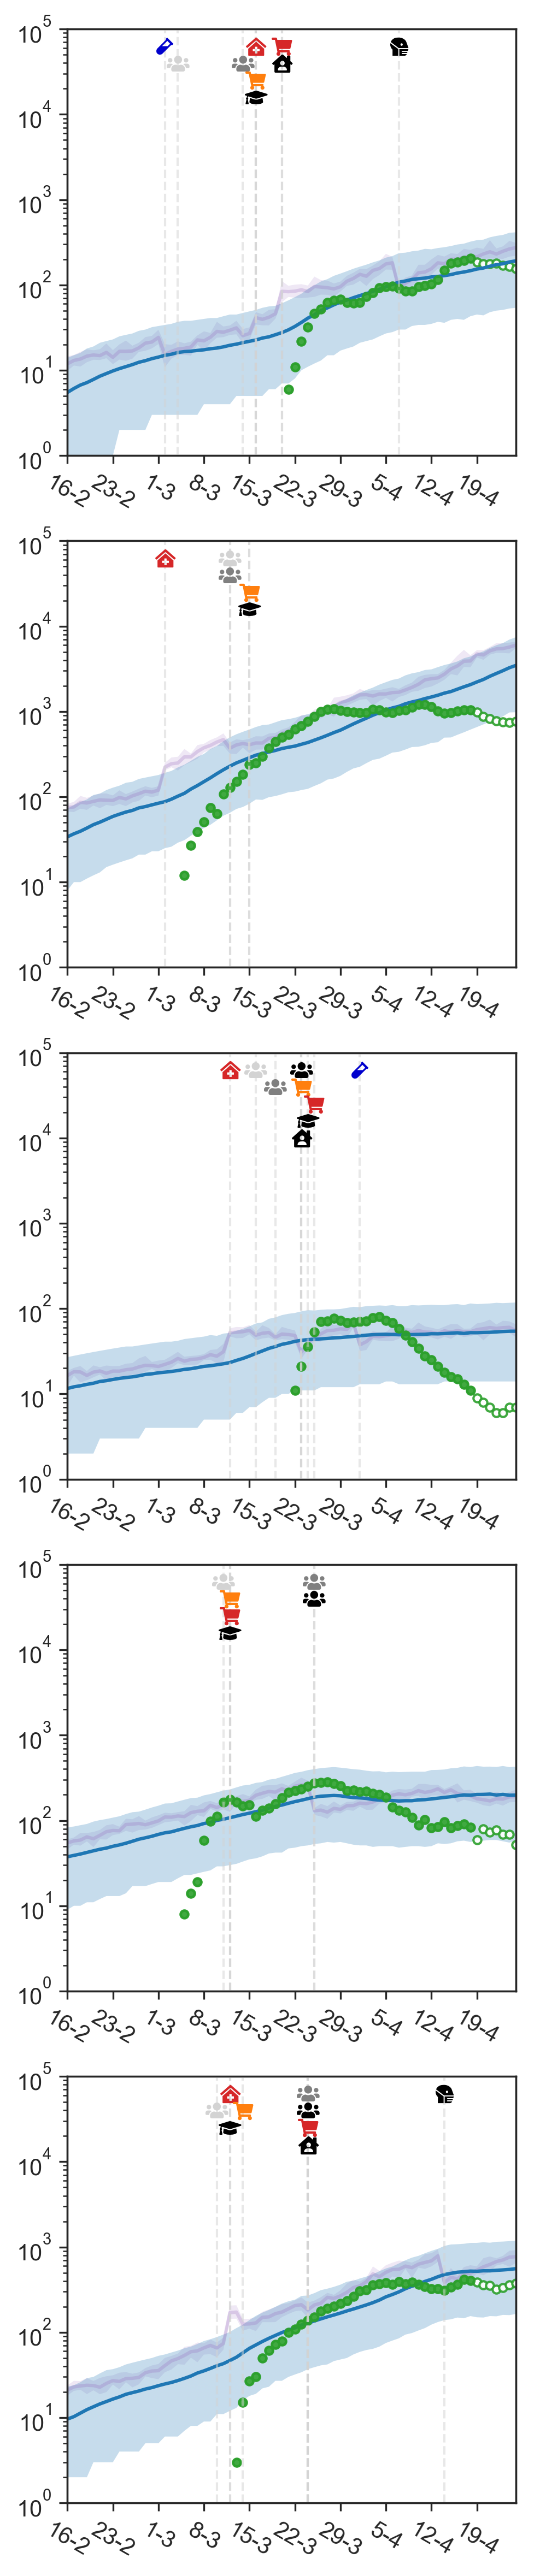

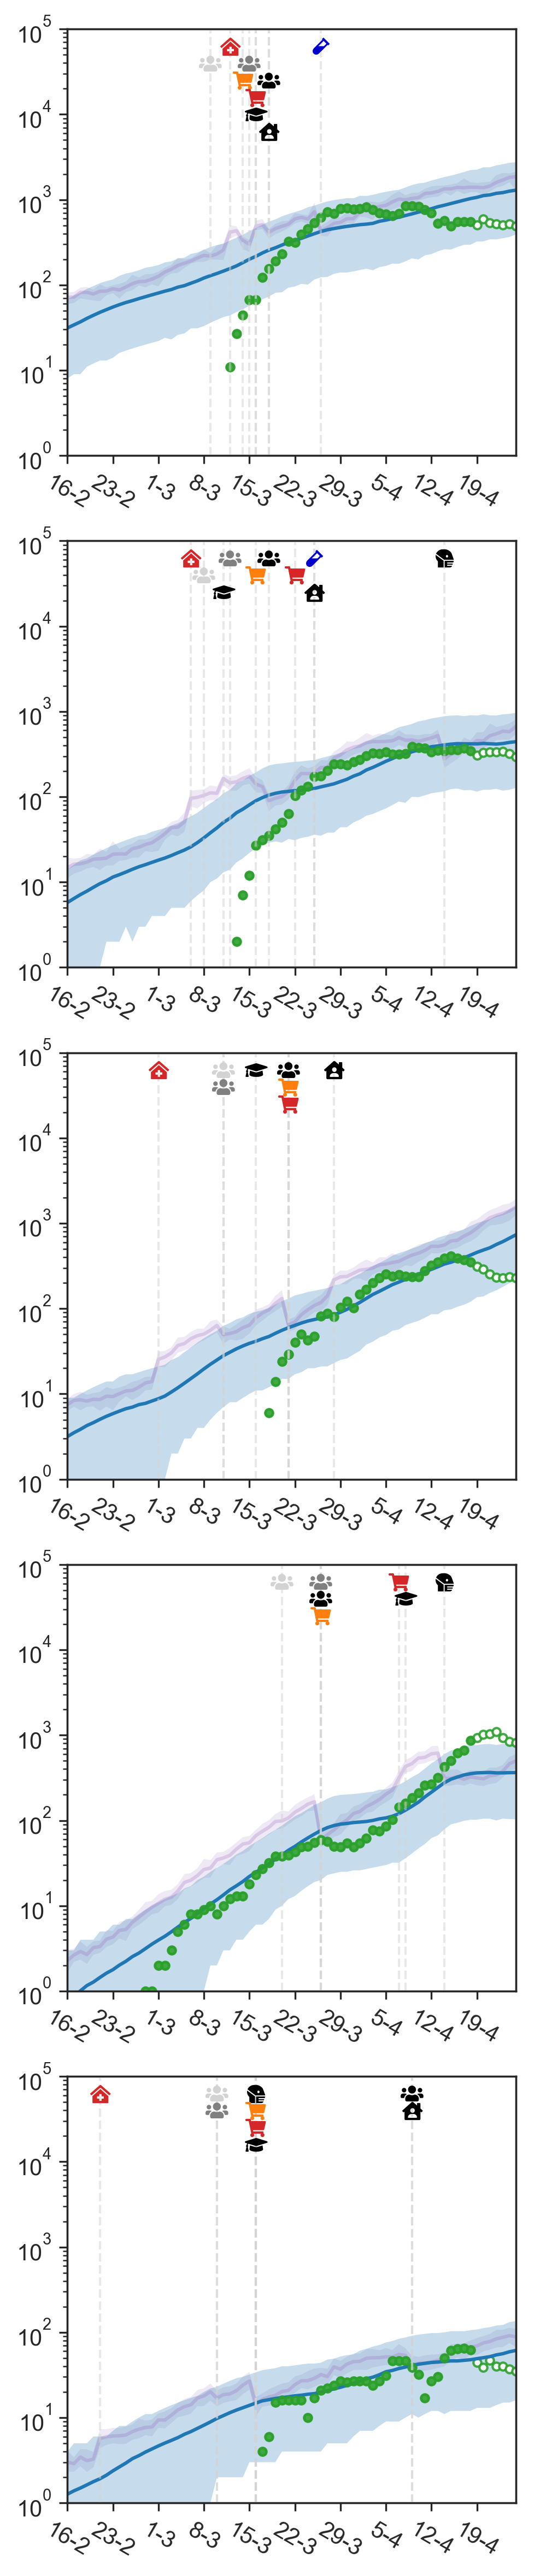

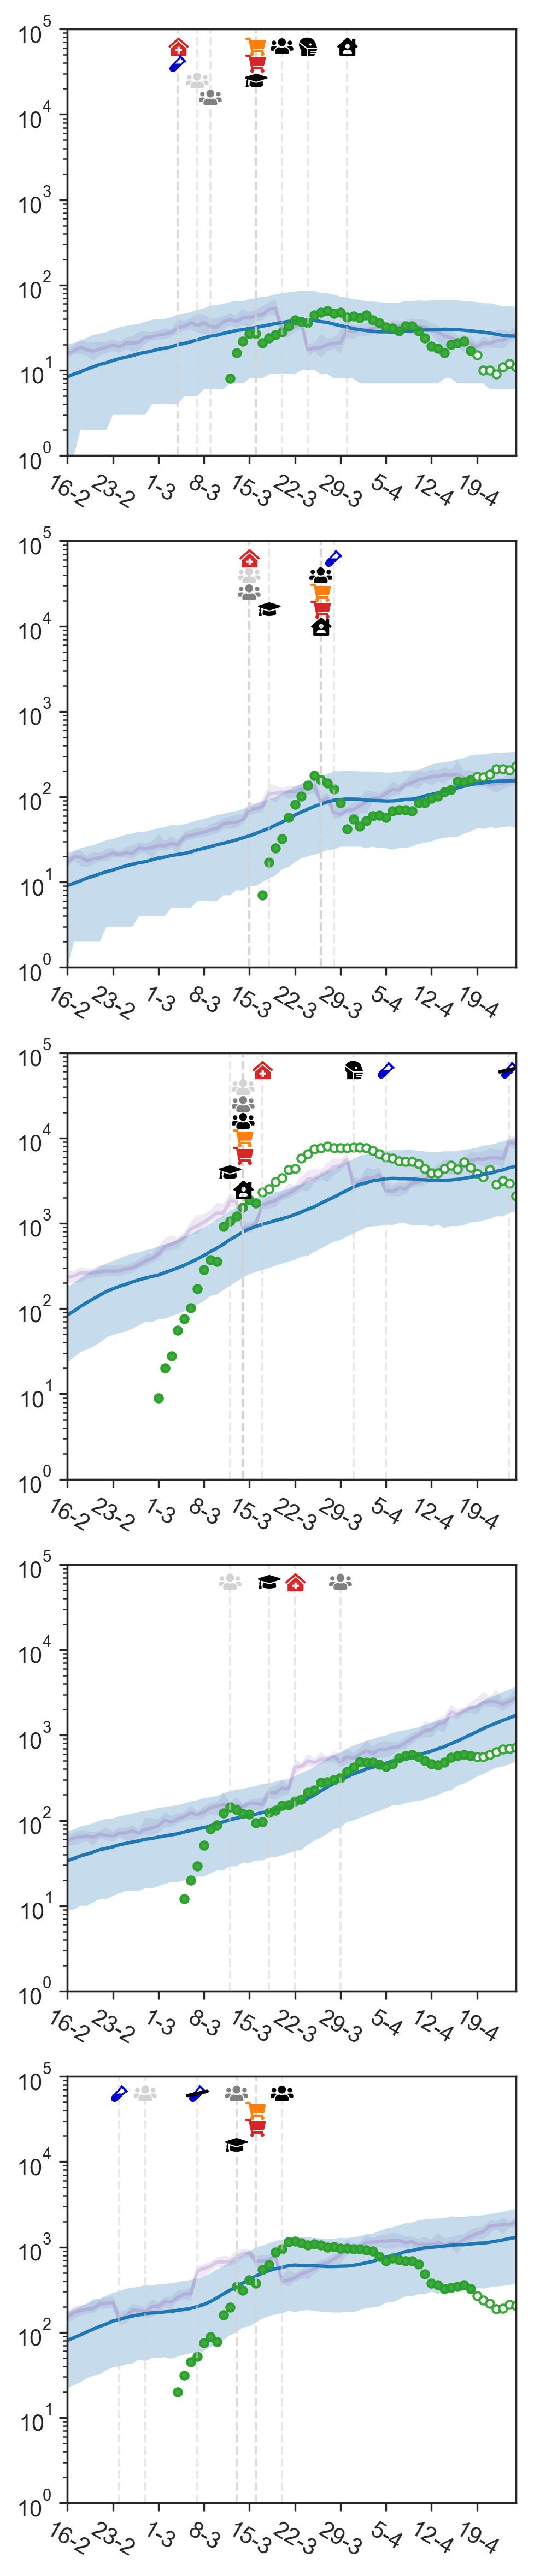

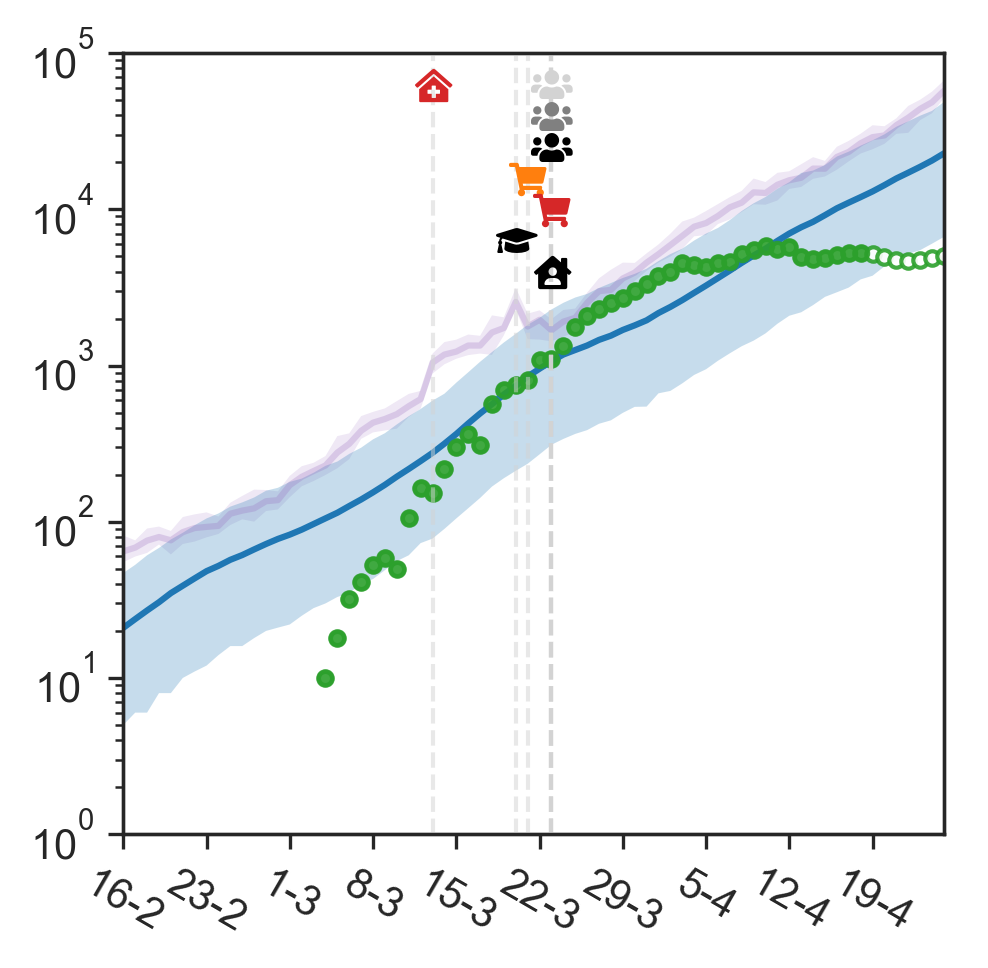

In [12]:
cm_plot_style = [
            ("\uf7f2", "tab:red"), # hospital symbol
            ("\uf963", "black"), # mask
            ("\uf492", "mediumblue"), # vial
            ("\uf0c0", "lightgrey"), # ppl
            ("\uf0c0", "grey"), # ppl
            ("\uf0c0", "black"), # ppl
            ("\uf07a", "tab:orange"), # shop 1
            ("\uf07a", "tab:red"), # shop2 
            ("\uf19d", "black"), # school
            ("\uf965", "black") # home
        ]

model.plot_region_predictions(cm_plot_style)

In [ ]:
model.plot_effect()

In [ ]:
for i, cm in enumerate(model.d.CMs):
    print(f"CM: {cm} mean: {np.mean(model.trace['CMReduction'][:, i]):.3f} [{np.percentile(model.trace['CMReduction'][:, i], 2.5):.3f}, {np.percentile(model.trace['CMReduction'][:, i], 97.5):.3f}]")

In [ ]:
np.mean(model.trace["CMReduction"][:, 0])

In [ ]:
with cm_effect.models.CMActive_Final_NB(data) as model2:
    model2.build_model()

In [ ]:
pm.model_to_graphviz(model2).render("model-active-final-alt")
pm.model_to_graphviz(model2)

In [ ]:
with model2.model:
    model2.trace = pm.sample(2000, chains=2)

In [ ]:
model2.plot_effect()

In [ ]:
model2.plot_region_predictions(cm_plot_style)

In [ ]:
model2.trace["CMReduction"][:, 0]

In [ ]:
np.mean(model2.trace["CMReduction"][:, 0])

In [ ]:
with cm_effect.models.CMActive_Final_NB(data) as model3:
    model3.build_model()

In [ ]:
pm.model_to_graphviz(model3).render("model-active-final")
pm.model_to_graphviz(model3)

In [ ]:
with model3.model:
    model3.trace = pm.sample(2000, chains=2)

In [ ]:
model3.plot_effect()

In [ ]:
model3.plot_region_predictions(cm_plot_style)

In [ ]:
model3.trace.varnames

In [ ]:
pm.traceplot(model3.trace, ["RegionLogR", "CM_Alpha", "InitialSize_log"])

In [ ]:
data.Deaths[0, :].data

In [ ]:
data.Confirmed[0, :].data

In [ ]:
data.Deaths[0, :].data

In [ ]:
data.Active[0, :]

In [ ]:
data.NewDeaths[0, :].data

In [ ]:
data.NewCases[0, :].data

In [ ]:
with cm_effect.models.CMActive_Final_NB(data) as model3:
    model3.build_model()

In [ ]:
pm.model_to_graphviz(model3).render("model-active-final")
pm.model_to_graphviz(model3)

In [ ]:
with model3.model:
    model3.trace = pm.sample(2000, chains=2)

In [ ]:
model3.plot_effect()

In [ ]:
model3.plot_region_predictions(cm_plot_style)

In [ ]:
with cm_effect.models.CMActive_Final(data) as model4:
    model4.build_model()